### Workflow  (Adapted from [Wilks 2019](https://www-sciencedirect-com.tudelft.idm.oclc.org/book/9780128158234/statistical-methods-in-the-atmospheric-sciences))  

This median-focused analysis evaluates scale differences in non-normal data through 4 key steps:  

1. **Normality Check**  
   - Shapiro-Wilk test ("Is the data bell-shaped?") + Q-Q plots  
   - Non-normal distributions → triggers non-parametric methods  


2. **Global Difference Test**  
   - Kruskal-Wallis H-test ("Do any bands differ?")  
   - If significant (p<0.01), proceed to pairwise tests  


3. **Pairwise Comparisons**  
   - **Mann-Whitney U**: Detects location shifts ("Does band X tend to have higher values than Y?")  
   - **Mood's Median**: Finds central tendency differences ("Are medians different?")  
   - **Kolmogorov-Smirnov**: Identifies full distribution differences ("Are shapes fundamentally different?")  
   - Bonferroni correction adjusts p-values for 3 comparisons  


4. **Bootstrap Validation**  
   - 1000 resamples → 99% CIs for median/IQR/skewness ("How stable are our estimates?")  
   - Avoids parametric assumptions about uncertainty  
   - Added to visualization as error bars in our estimates.

Visualizations (boxplots, ratio plots) complement statistical tests. The workflow prioritizes robust methods per Wilks' guidance for atmospheric data analysis.  

#### Flowchart

<div style="text-align: center;">
    <img src="images/workflow_flowchart.png" alt="alt text" width="1300">
</div>


### Results

The band ratios (Band0/Band1 = $\approx 500$ and Band1/Band2= $\approx 2$) provide direct evidence of scale dependence of the power $(\text{FFT}(\sigma(\bf{x})))^2$ in our data, showing how the power drops as we move from larger to smaller scales. 

Across all pairwise comparisons, the p-values are essentially zero, strongly indicating that the differences in power levels between bands are statistically significant. The Kolmogorov-Smirnov (K-S) test further confirmed that the distributions differ beyond just location shifts, reinforcing that the scale dependence is not merely a shift in central tendency but a more fundamental change in distributional properties.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, levene, ks_2samp, shapiro, bartlett, f_oneway, kruskal
from statsmodels.stats.multitest import multipletests
from utils.functions import *

Length of dfs before any filtering: df_wv1 = 36925, df_wv2 = 37000.
Length of dfs after filtering on 0 < mean_sigma0 < 1: 36868, 36949.
Length of dfs after filtering on 0 < mean_psd_band0 < 1e6: 35857, 36949.
Length of dfs after filtering on 0 < mean_psd_band1 < 4000: 33638, 36941.
Length of dfs after filtering on 0 < mean_psd_band2 < 2000: 30187, 36941.


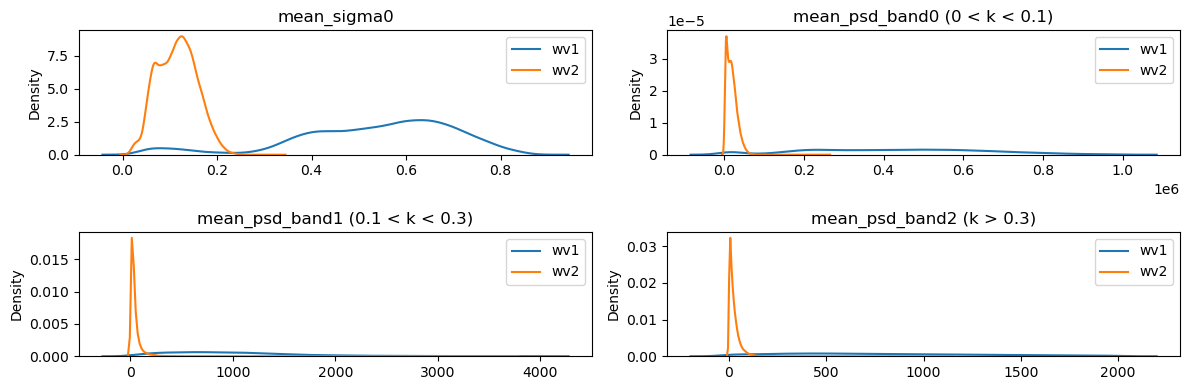

In [2]:
# read parquet

df_wv1 = pd.read_parquet('processed_data/wv1_unstable_gt15.parquet')
df_wv2 = pd.read_parquet('processed_data/wv2_unstable_gt15.parquet')

print(f"Length of dfs before any filtering: df_wv1 = {len(df_wv1)}, df_wv2 = {len(df_wv2)}.")

# Filter data
df_wv1 = df_wv1[(df_wv1.mean_sigma0 > 0) & (df_wv1.mean_sigma0 < 1)]
df_wv2 = df_wv2[(df_wv2.mean_sigma0 > 0) & (df_wv2.mean_sigma0 < 1)]

print(f"Length of dfs after filtering on 0 < mean_sigma0 < 1: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band0 > 0) & (df_wv1.mean_psd_band0 < 1e6)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band0 > 0) & (df_wv2.mean_psd_band0 < 1e6)]

print(f"Length of dfs after filtering on 0 < mean_psd_band0 < 1e6: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band1 > 0) & (df_wv1.mean_psd_band1 < 4000)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band1 > 0) & (df_wv2.mean_psd_band1 < 4000)]

print(f"Length of dfs after filtering on 0 < mean_psd_band1 < 4000: {len(df_wv1)}, {len(df_wv2)}.")

df_wv1 = df_wv1[(df_wv1.mean_psd_band2 > 0) & (df_wv1.mean_psd_band2 < 2000)]
df_wv2 = df_wv2[(df_wv2.mean_psd_band2 > 0) & (df_wv2.mean_psd_band2 < 2000)]

print(f"Length of dfs after filtering on 0 < mean_psd_band2 < 2000: {len(df_wv1)}, {len(df_wv2)}.")

# Create figure and subplots
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 4))

# First subplot - mean_sigma0
sns.kdeplot(data=df_wv1.mean_sigma0.values, label="wv1", ax=ax1)
sns.kdeplot(data=df_wv2.mean_sigma0.values, label="wv2", ax=ax1)
ax1.set_title('mean_sigma0')
ax1.legend()

# Second subplot - mean_psd_band0
sns.kdeplot(data=df_wv1.mean_psd_band0.values, label="wv1", ax=ax2)
sns.kdeplot(data=df_wv2.mean_psd_band0.values, label="wv2", ax=ax2)
ax2.set_title('mean_psd_band0 (0 < k < 0.1)')
ax2.legend()

# Third subplot - mean_psd_band1
sns.kdeplot(data=df_wv1.mean_psd_band1.values, label="wv1", ax=ax3)
sns.kdeplot(data=df_wv2.mean_psd_band1.values, label="wv2", ax=ax3)
ax3.set_title('mean_psd_band1 (0.1 < k < 0.3)')
ax3.legend()

# Fourth subplot - mean_psd_band2
sns.kdeplot(data=df_wv1.mean_psd_band2.values, label="wv1", ax=ax4)
sns.kdeplot(data=df_wv2.mean_psd_band2.values, label="wv2", ax=ax4)
ax4.set_title('mean_psd_band2 (k > 0.3)')
ax4.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


SCALE DEPENDENCE ANALYSIS

Analysis Parameters:
- Bootstrap Samples: 1000
- Confidence Level: 99.0%
- Significance Level (alpha): 0.01

--------------------------------------------------------------------------------
STEP 1: NORMALITY ASSESSMENT
--------------------------------------------------------------------------------

WV1 Normality Results:
  mean_psd_band0:
    Normal: False
    Shapiro-Wilk p-value: 6.85e-21
  mean_psd_band1:
    Normal: False
    Shapiro-Wilk p-value: 1.80e-46
  mean_psd_band2:
    Normal: False
    Shapiro-Wilk p-value: 7.18e-35

WV2 Normality Results:
  mean_psd_band0:
    Normal: False
    Shapiro-Wilk p-value: 4.03e-40
  mean_psd_band1:
    Normal: False
    Shapiro-Wilk p-value: 8.03e-85
  mean_psd_band2:
    Normal: False
    Shapiro-Wilk p-value: 2.16e-74

Generating QQ plots for visual inspection...
QQ plots saved as 'normality_qq_plots.png'

--------------------------------------------------------------------------------
STEP 2: BOOTSTRAP ANALYSIS


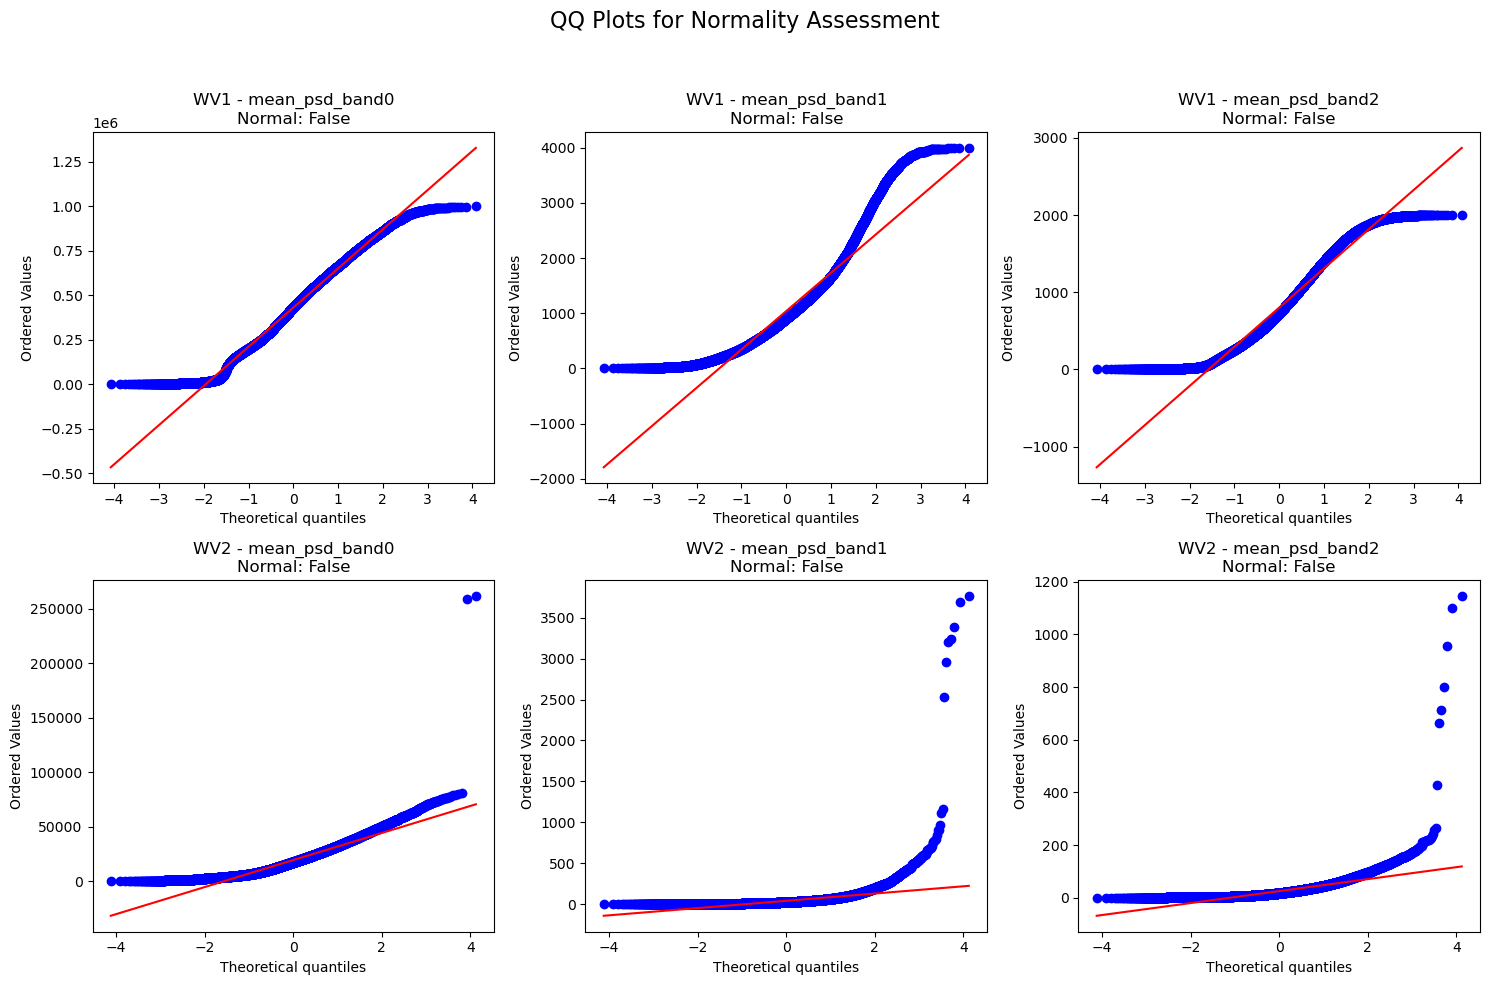

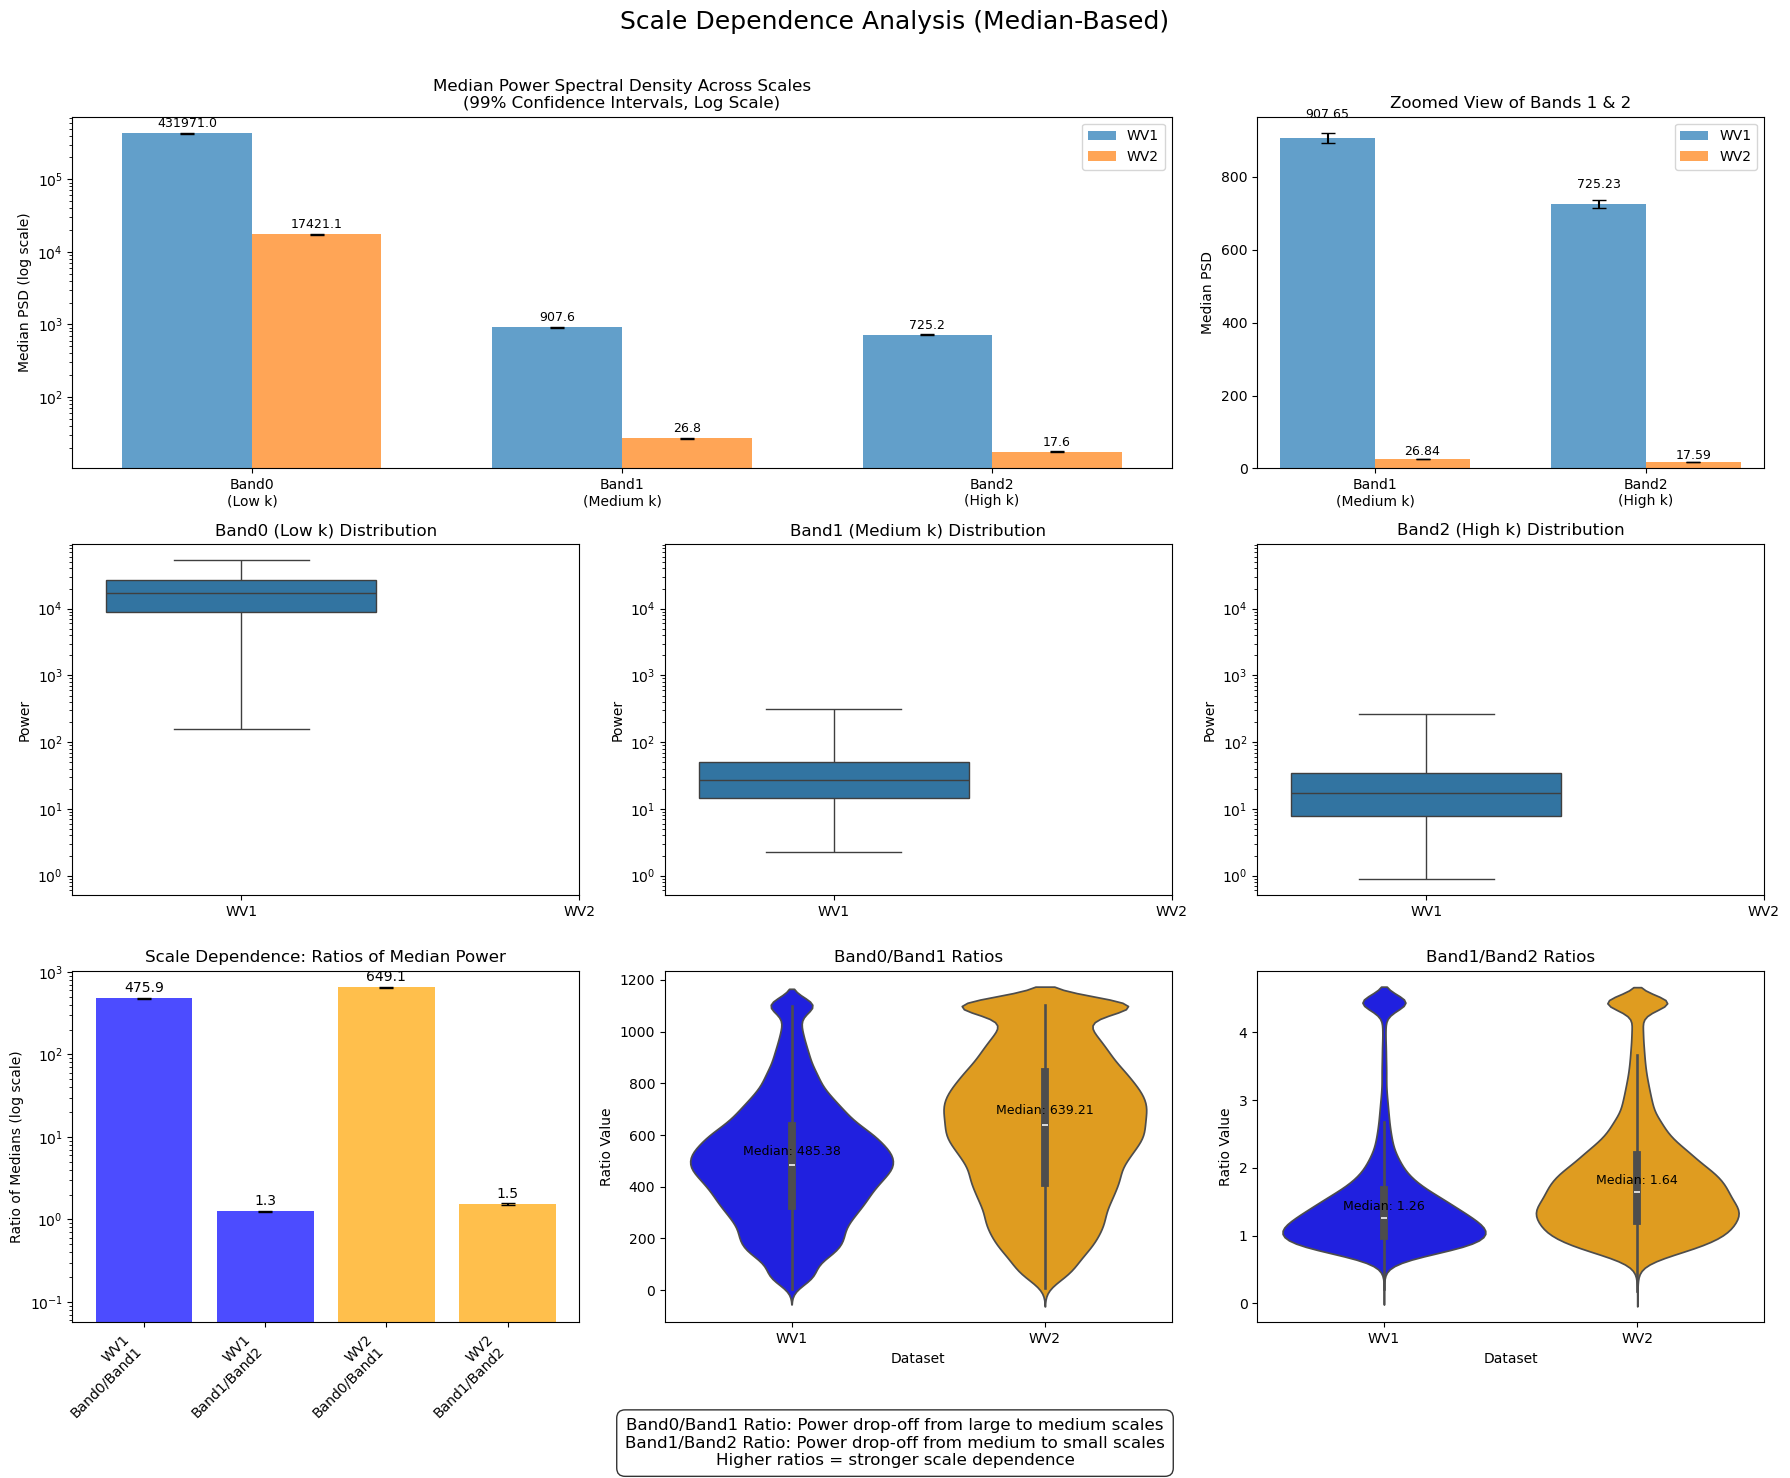

In [3]:
results, summary = analyze_scale_dependence(df_wv1, df_wv2, bootstrap_samples=1000, confidence=0.99, alpha=0.01)

In [5]:
df_wv1.columns

Index(['value', 'wm_type', 'lonlat_center', 'tif_path', 'process_status',
       'class_1', 'prob_1', 'class_2', 'prob_2', 'class_3', 'prob_3',
       'all_prob', 'processing_time', 'filename', 'date_time', 'latitude',
       'longitude', 'L', 'wspd', 'wdir', 'sst', 'airt', 'p', 'rh', 'blh',
       'msdwswrf', 'msdwlwrf', 'renamed_filename', 'exists_ok',
       'path_to_sar_file', 'mean_sigma0', 'var_sigma0', 'skewness_sigma0',
       'spectral_stats', 'kurtosis_sigma0', 'mean_psd2d', 'var_psd2d',
       'skewness_psd2d', 'kurtosis_psd2d', 'mean_psd_band0', 'var_psd_band0',
       'skewness_psd_band0', 'kurtosis_psd_band0', 'mean_psd_band1',
       'var_psd_band1', 'skewness_psd_band1', 'kurtosis_psd_band1',
       'mean_psd_band2', 'var_psd_band2', 'skewness_psd_band2',
       'kurtosis_psd_band2', 'bandratio0_1', 'bandratio1_2'],
      dtype='object')